# GENERATING WINDOWED DATASET
* The following program is meant to create a dataset from a series of Brightfield images
  * Temperature dependent images in a folders of ramp_up images and ramp_down.
  * Preprocessing:
    * Apply Gaussian filtering to entire image
    * Create stack of sliding windows
    * Apply Hanning window and 2D FFT
    
* If you are downloading the windowed dataset straight from Zenodo, skip to the next notebook

# Imports

## Install packages

In [ ]:
# we will need the sidpy package and pyNSID and SciFIreaders
!pip install sidpy;
#git+https://github.com/pycroscopy/sidpy.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 4.3 MB/s  eta 0:00:01
     |████████████████████████████████| 1.6 MB 38.7 MB/s 
     |████████████████████████████████| 1.6 MB 20.4 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=9f11fed835b907c9fa5914d6a308aa2215650db2faa74f5641fd599e04aa2088
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [ ]:
!pip install pyNSID;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyUSID;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66 kB 5.2 MB/s  eta 0:00:01


In [ ]:
#MAKE SURE TO RESTART RUNTIME AFTER RUNNING THIS CELL!
!pip install pycroscopy=='0.61.0-alpha';

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 48.5 MB/s 
     |████████████████████████████████| 154 kB 61.3 MB/s 


In [ ]:
pip install --upgrade moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 388 kB 8.0 MB/s 
     |████████████████████████████████| 26.9 MB 2.2 MB/s 
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110743 sha256=7e7baf2594f9fad2dcba77ce7fc21a49d6b8c84eea669183d875f4c983ee9be8
  Stored in directory: /root/.cache/pip/wheels/56/dc/2b/9cd600d483c04af3353d66623056fc03faed76b7518faae4df
Successfully built moviepy
  Attempting uninstall: moviepy
    Found existing installation: moviepy 0.2.3.5
    Uninstalling moviepy-0.2.3.5:
      Successfully uninstalled moviepy-0.2.3.5


## For google colab:
* Mount to drive and move to current folder
* Make a shortcut and change directory into it
* Append to sys.path so we can reference files from here

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/BF

/content/drive/.shortcut-targets-by-id/1LVp9nNW5PbOBQNdcd-Ypp47CXFZ2NYs9/BF


In [ ]:
import sys
import os
# append to sys.path so we can reference files from here
sys.path.append(os.getcwd())
print(sys.path)

['/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/.shortcut-targets-by-id/1LVp9nNW5PbOBQNdcd-Ypp47CXFZ2NYs9/BF']


## Imports

In [1]:
# General utilities:
import requests
from time import time
import datetime
from os.path import join as pjoin
import glob as glob
from pdb import set_trace as bp
import re
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import h5py
import math
import pickle
from collections import OrderedDict
from tqdm import tqdm
from pprint import pprint

#Vis
import imageio
from sklearn.preprocessing import StandardScaler
from skimage.color import rgb2gray
from skimage.filters import difference_of_gaussians, window
from skimage import morphology
from skimage.filters import *
from skimage.transform import rescale
from skimage.feature import peak_local_max
from skimage import data, img_as_float
from scipy import ndimage
from scipy.fft import fftn, fftshift
import cv2
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Pycroscopy
import sidpy
import pyNSID
print('sidpy version: ', sidpy.__version__)
import pycroscopy as px
from pycroscopy.image import ImageWindowing
import dask.array as da

# NN
import torch
import torch.autograd as autograd
from torch.autograd import Variable
from torch.autograd import Function
import torchvision
from torchvision import datasets, models
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# My Utilities
import utils
import io_utils

sidpy version:  0.0.7
sidpy version:  0.0.7


# 1. Windowing
* You only need to do this section one time for each new dataset.
* SKIP the entire windowing section if you are downloading data from zenodo

In [2]:
env = 'Annealed' # name of folder with the original bright field images
combined = f'Combined_BF_{env}_cropped.h5' # name of h5 file with cropped/filtered data, and fft images
emb = f'Embeddings_{env}.h5' # name of h5 file with embeddings
f = f'BF_jVAE_{env}' # folder with saved checkpoints on embedding movies

In [3]:
# make list of file names for original bright field images
temps = utils.get_temps(env)
t_len=len(temps)
print('number of images: ', t_len)

number of images:  43


## Apply gaussian filters and crop into square. Load into h5 file
* Starting from the raw BF images, crop a square area for easier analysis. 
* Filter it with a gaussian filter for better quality fft images.
* Write the images into a combined dataset.

In [4]:
c1,c2,step = 200,300,1400

utils.write_cropped_filtered_h5(c1,c2,step,combined,temps)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:19<00:00,  2.22it/s]


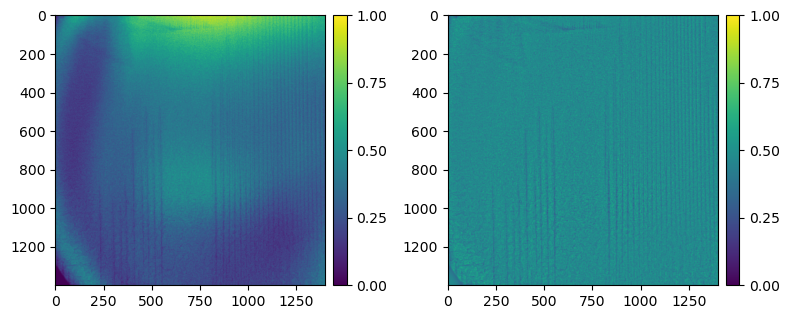

In [8]:
# Take a look at the h5 file we just wrote

h = h5py.File(combined,'a')
i=-1 # examine different indices to make sure all are cropped alright

fig,ax = plt.subplots(1,2)
a=ax[0].imshow(h['All'][i])
utils.add_colorbar(fig,a)
a=ax[1].imshow(h['All_filtered'][i])
utils.add_colorbar(fig,a)


## use pycroscopy to create windows and apply fft on BF image
* This allows us to see changes in frequencies when the needles point different directions
* for more information on parameters, consult ImageWindowing object documentation:
https://github.com/pycroscopy/pycroscopy/blob/main/pycroscopy/image/image_window.py

In [ ]:
# set windowing parameters
parms_dict = {}

# Window parameters: you can tune these to make image higher resolution. 
# Smaller step size will result in higher resolution,
parms_dict['window_step_x'] = 32
parms_dict['window_step_y'] = 32
parms_dict['window_size_x'] = 128
parms_dict['window_size_y'] = 128

#Mode parameters
parms_dict['mode'] = 'fft' # want data in reciprocal space for jVAE
parms_dict['fft_mode'] = 'abs' # return absolute values of fft
parms_dict['interpol_factor'] = 2.3 
parms_dict['zoom_factor'] = 2 #NOTE: Must be integer

pprint(parms_dict)

{'fft_mode': 'abs',
 'interpol_factor': 2.3,
 'mode': 'fft',
 'window_size_x': 128,
 'window_size_y': 128,
 'window_step_x': 32,
 'window_step_y': 32,
 'zoom_factor': 2}


In [ ]:
h = h5py.File(combined,'a')
images=h['All_filtered'][:]

utils.write_fft_windows(images,combined,temps,parms_dict,
                  grp = '128_fft_windows',
                  dset = '128_fft_windows_dataset',
                  logset = '128_fft_windows_logdata')

image test is shape (128, 128)
image zoomed is shape (64, 64)
image zoomed interpol is shape (147, 147)


100%|██████████| 43/43 [27:33<00:00, 38.45s/it]


## Read in from h5 and check

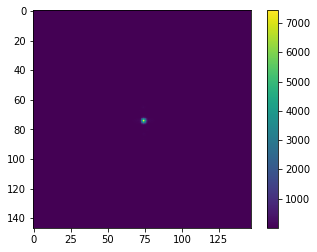

In [ ]:
hf = h5py.File(combined, 'a')
hf.keys()

# Check unprocessed fft windows
plt.imshow(hf['128_fft_windows']['128_fft_windows_dataset'][0])
plt.colorbar()
plt.show()
# Check resized log fft windows
plt.imshow(hf['128_fft_windows']['128_fft_windows_logdata'][0][0])
plt.colorbar()
plt.show()

# Export to Zenodo
* Write the combined file into a new dataset.
* you can also add metadata afterwards using the insert_metadata function. Consult the [developers page](https://developers.zenodo.org/#quickstart-upload) on zenodo for metadata entries
* For smaller datasets, you can write to an existing deposition. 
* NOTE: The Access Token below is for my own zenodo account. If you would like to upload to your own zenodo, you will need to make an account and generate an access token from you profile.


In [ ]:
ACCESS_TOKEN = ...
r = requests.get('https://zenodo.org/api/deposit/depositions', params={'access_token': ACCESS_TOKEN})
pprint(r.json()) # uncomment to see list of json for each deposition

[{'conceptrecid': '6633643',
  'created': '2022-06-10T21:23:19.070761',
  'doi': '',
  'doi_url': 'https://doi.org/',
  'id': 6633644,
  'links': {'discard': 'https://zenodo.org/api/deposit/depositions/6633644/actions/discard',
            'edit': 'https://zenodo.org/api/deposit/depositions/6633644/actions/edit',
            'files': 'https://zenodo.org/api/deposit/depositions/6633644/files',
            'html': 'https://zenodo.org/deposit/6633644',
            'latest_draft': 'https://zenodo.org/api/deposit/depositions/6633644',
            'latest_draft_html': 'https://zenodo.org/deposit/6633644',
            'publish': 'https://zenodo.org/api/deposit/depositions/6633644/actions/publish',
            'self': 'https://zenodo.org/api/deposit/depositions/6633644'},
  'metadata': {'access_right': 'open',
               'creators': [{'affiliation': 'Lehigh University',
                             'name': 'Zhang, Xinqiao'}],
               'description': 'Placeholder',
               'doi

In [ ]:
# post a new dataset. Skip if you are adding a file to an existing dataset
r = io_utils.post_dataset(ACCESS_TOKEN,combined,os.getcwd())
pprint(r.json()) # Look for the deposition id

100%|██████████| 39.5G/39.5G [10:40<00:00, 66.3MB/s]


{'checksum': 'md5:b12e3ab31b54b4cc899cf51a348d4daf',
 'created': '2022-06-10T21:23:21.027313+00:00',
 'delete_marker': False,
 'is_head': True,
 'key': 'Combined_BF_Oxygen_cropped.h5',
 'links': {'self': 'https://zenodo.org/api/files/93e87e15-ce90-4092-9742-d09bb3387590/Combined_BF_Oxygen_cropped.h5',
           'uploads': 'https://zenodo.org/api/files/93e87e15-ce90-4092-9742-d09bb3387590/Combined_BF_Oxygen_cropped.h5?uploads',
           'version': 'https://zenodo.org/api/files/93e87e15-ce90-4092-9742-d09bb3387590/Combined_BF_Oxygen_cropped.h5?versionId=94aef07d-9cd2-4567-9aab-a3740d78b97d'},
 'mimetype': 'application/octet-stream',
 'size': 42457562816,
 'updated': '2022-06-10T21:23:21.032718+00:00',
 'version_id': '94aef07d-9cd2-4567-9aab-a3740d78b97d'}


In [ ]:
r.json()

JSONDecodeError: ignored

In [ ]:
# you can also add metadata afterwards using the insert_metadata function.
# Consult the developers page on zenodo for metadata fields

metadata = {"metadata": {
                    f'title": "Combined {env}', # edit
                    "upload_type": "dataset",
                    "description": "Cropped, filtered, and fft windowed datasets",
                    "creators": [{"name": "Zhang, Xinqiao", "affiliation": "Lehigh University"}],
                    "access_right": 'restricted',
                    'access_conditions': 'Collaborating with M3'

                    }
                }

deposition_id = 6633644 ## YOU CAN CHANGE THIS MANUALLY

r = io_utils.insert_metadata(ACCESS_TOKEN,
                    deposition_id, metadata)

pprint(r.json()) ## check that metadata has uploaded

{'conceptrecid': '6633643',
 'created': '2022-06-10T21:23:19.070761+00:00',
 'doi': '',
 'doi_url': 'https://doi.org/',
 'files': [{'checksum': 'b12e3ab31b54b4cc899cf51a348d4daf',
            'filename': 'Combined_BF_Oxygen_cropped.h5',
            'filesize': 42457562816,
            'id': 'cfc9d833-a8d5-43e1-b135-10449fe05474',
            'links': {'download': 'https://zenodo.org/api/files/93e87e15-ce90-4092-9742-d09bb3387590/Combined_BF_Oxygen_cropped.h5',
                      'self': 'https://zenodo.org/api/deposit/depositions/6633644/files/cfc9d833-a8d5-43e1-b135-10449fe05474'}}],
 'id': 6633644,
 'links': {'bucket': 'https://zenodo.org/api/files/93e87e15-ce90-4092-9742-d09bb3387590',
           'discard': 'https://zenodo.org/api/deposit/depositions/6633644/actions/discard',
           'edit': 'https://zenodo.org/api/deposit/depositions/6633644/actions/edit',
           'files': 'https://zenodo.org/api/deposit/depositions/6633644/files',
           'html': 'https://zenodo.org/de

In [ ]:
# to add a new dataset, use the  insert_dataset function
# insert the full path into filename prompt

deposition_id = 6633644 ## YOU CAN CHANGE THIS MANUALLY

r = io_utils.insert_dataset(ACCESS_TOKEN,
               deposition_id,
              f'/home/xinqiao/new_mount/BF/{combined}')

pprint(r.json()) ## Check that new dataset has been inserted

FileNotFoundError: ignored

In [ ]:
deposition_id = 6633644 # change this when you are ready to publish a deposition
r = requests.post(f'https://zenodo.org/api/deposit/depositions/{deposition_id}/actions/publish',
                      params={'access_token': ACCESS_TOKEN} )